In [170]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

In [171]:
from summer2 import CompartmentalModel
from summer2.parameters import Parameter

**Model 1: Simple SIR**

In [172]:
def build_model():
    m = CompartmentalModel([0,100], ["S","I","R"],"I",ref_date=datetime(2020,6,1))
    m.set_initial_population({"S": 13781001.0, "I": 3622.0, "R": 14178.0})
    m.add_infection_frequency_flow("infection", Parameter("contact_rate"),"S","I") 
    m.add_transition_flow("recovery", 0.0714,"I","R") 
    m.request_output_for_flow("infection", "infection")
    m.request_output_for_flow("recovery", "recovery")
    return m

In [173]:
m = build_model()

In [174]:
parameters = {"contact_rate": 0.43}

In [175]:
m.run(parameters)

<Axes: >

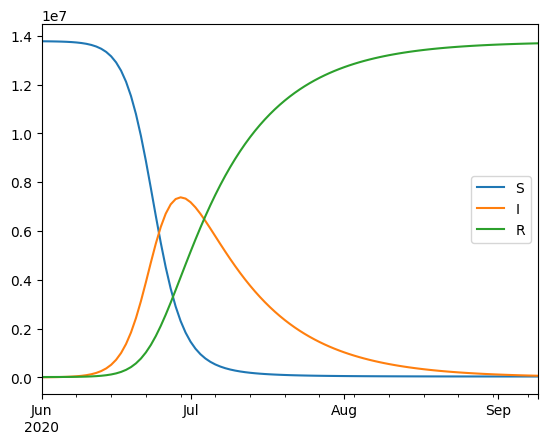

In [176]:
m.get_outputs_df().plot()

<Axes: >

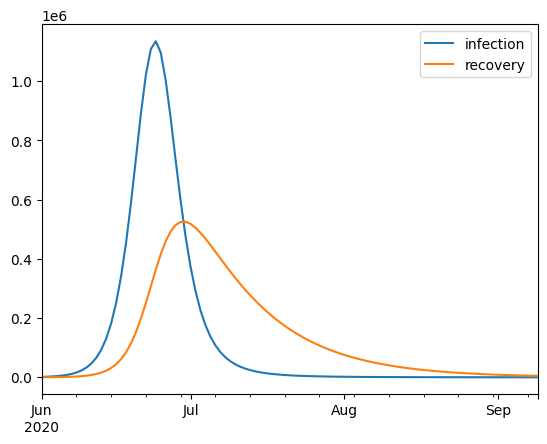

In [177]:
m.get_derived_outputs_df().plot()

In [178]:
df=pd.read_excel(io='InfectionsData_060120_093020.xlsx',index_col=0)
inf_data = df["INFECTIONS"]

In [179]:
inf_data_cal = inf_data[:61]

<Axes: xlabel='DATE'>

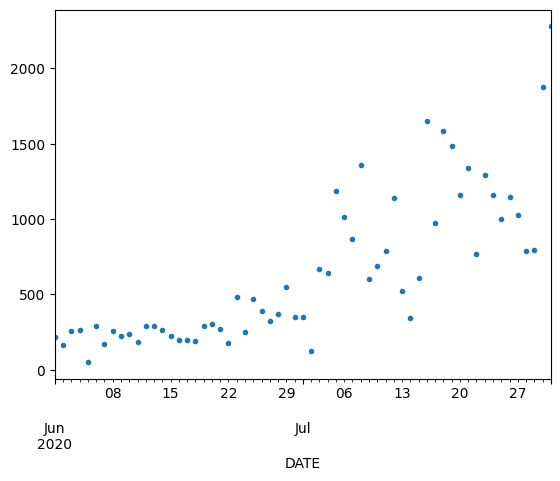

In [180]:
inf_data_cal.plot(style='.')

**Calibration**

In [181]:
# Targets represent data we are trying to fit to
from estival import targets as est

# We specify parameters using (Bayesian) priors
from estival import priors as esp

# Finally we combine these with our summer2 model in a BayesianCompartmentalModel (BCM)
from estival.model import BayesianCompartmentalModel

In [182]:
targets = [
    est.NormalTarget("infection", inf_data_cal, np.std(inf_data_cal) * 0.1),
]

In [183]:
priors = [
    esp.UniformPrior("contact_rate", (0.001,0.1)),
]

In [184]:
defp = {"contact_rate": 0.005}

In [185]:
bcm = BayesianCompartmentalModel(m, defp, priors, targets)
from estival.wrappers import pymc as epm
import pymc as pm

In [186]:
with pm.Model() as model:

    # This is all you need - a single call to use_model
    variables = epm.use_model(bcm)

    # The log-posterior value can also be output, but may incur additional overhead
    # Use jacobian=False to get the unwarped value (ie just the 'native' density of the priors
    # without transformation correction factors)
    # pm.Deterministic("logp", model.logp(jacobian=False))

    # Now call a sampler using the variables from use_model
    # In this case we use the Differential Evolution Metropolis sampler
    # See the PyMC docs for more details
    idata = pm.sample(step=[pm.DEMetropolis(variables)], draws=8000, tune=0,cores=4,chains=4)

Population sampling (4 chains)
DEMetropolis: [contact_rate]
Attempting to parallelize chains to all cores. You can turn this off with `pm.sample(cores=1)`.


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 0 tune and 8_000 draw iterations (0 + 32_000 draws total) took 14 seconds.


**Visualizing Outputs**

In [187]:
import arviz as az

In [188]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
contact_rate,0.095,0.002,0.092,0.097,0.0,0.0,6203.0,6368.0,1.0


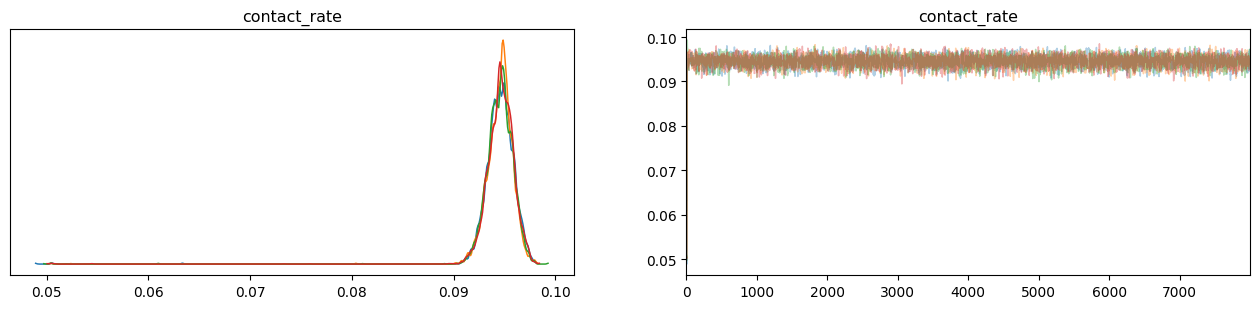

In [189]:
az.plot_trace(idata, figsize=(16,3.2*len(idata.posterior)),compact=False);#, lines=[("m", {}, mtrue), ("c", {}, ctrue)]);

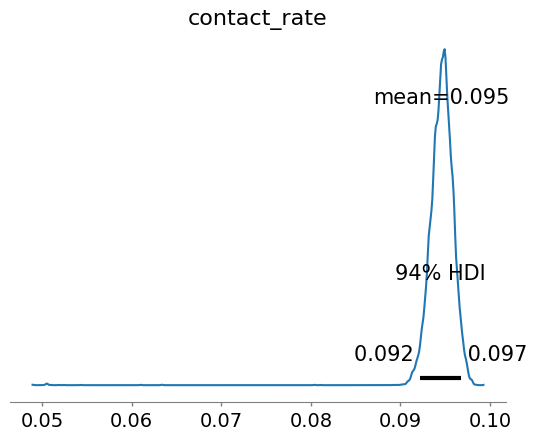

In [190]:
az.plot_posterior(idata);

**Obtaining Likelihood**

In [191]:
from estival.sampling.tools import likelihood_extras_for_idata

In [192]:
likelihood_df = likelihood_extras_for_idata(idata, bcm)

<Axes: xlabel='draw'>

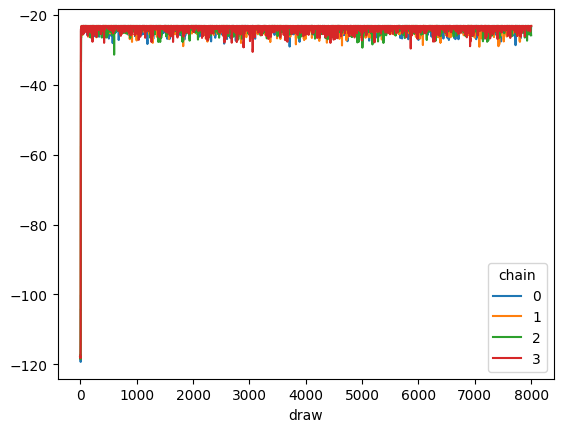

In [193]:
ldf_pivot = likelihood_df.reset_index(level="chain").pivot(columns=["chain"])

ldf_pivot["logposterior"].plot()

In [194]:
# Sort this DataFrame by logposterior to obtain the MAP index
ldf_sorted = likelihood_df.sort_values(by="logposterior",ascending=False)

# Extract the parameters from the calibration samples
map_params = idata.posterior.to_dataframe().loc[ldf_sorted.index[0]].to_dict()

map_params

{'contact_rate': 0.09469974761383611}

In [195]:
bcm.loglikelihood(**map_params), ldf_sorted.iloc[0]["loglikelihood"]

(Array(-25.51325881, dtype=float64), -25.5132588097123)

In [196]:
map_res = bcm.run(map_params)

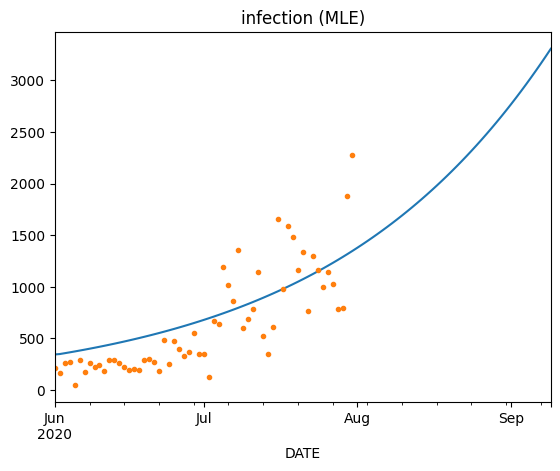

In [197]:
variable = "infection"

pd.Series(map_res.derived_outputs[variable]).plot(title = f"{variable} (MLE)")
bcm.targets[variable].data.plot(style='.');

**Compare with Actual Data for August 2020**

<Axes: title={'center': 'infection (MLE)'}, xlabel='DATE'>

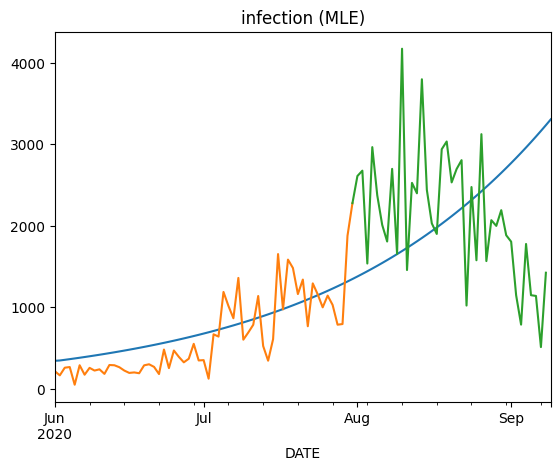

In [198]:
pd.Series(map_res.derived_outputs[variable]).plot(title = f"{variable} (MLE)")
inf_data[:61].plot()
inf_data[60:100].plot()

**Uncertainty Sampling**

In [199]:
sample_idata = az.extract(idata, num_samples = 400)
samples_df = sample_idata.to_dataframe().drop(columns=["chain","draw"])

In [200]:
from estival.utils.parallel import map_parallel

In [201]:
def run_sample(idx_sample):
    idx, params = idx_sample
    return idx, bcm.run(params)

In [202]:
sample_res = map_parallel(run_sample, samples_df.iterrows(), n_workers=4)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [203]:
import xarray as xr

In [204]:
xres = xr.DataArray(np.stack([r.derived_outputs for idx, r in sample_res]),
                    dims=["sample","time","variable"])
xres = xres.assign_coords(sample=sample_idata.coords["sample"],
                          time=map_res.derived_outputs.index, variable=map_res.derived_outputs.columns)

In [205]:
# Set some quantiles to calculate
quantiles = (0.01,0.05,0.25,0.5,0.75,0.95,0.99)

# Generate a new DataArray containing the quantiles
xquantiles = xres.quantile(quantiles,dim=["sample"])

In [206]:
# Extract these values to a pandas DataFrame for ease of plotting

uncertainty_df = xquantiles.to_dataframe(name="value").reset_index().set_index("time").pivot(columns=("variable","quantile"))["value"]

<Axes: title={'center': 'infection'}, xlabel='DATE'>

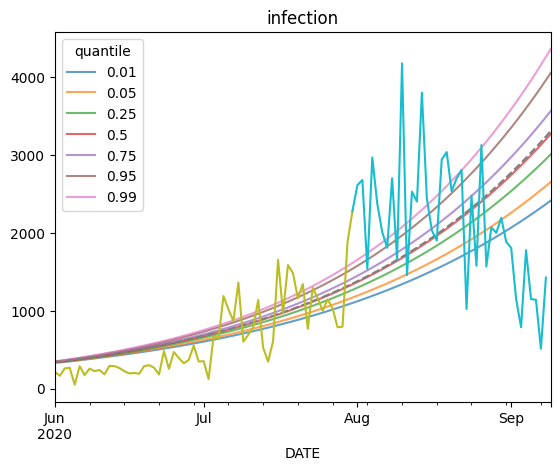

In [210]:
variable = "infection"

fig = uncertainty_df[variable].plot(title=variable,alpha=0.7)
pd.Series(map_res.derived_outputs[variable]).plot(style='--')
inf_data[:61].plot()
inf_data[60:100].plot()